# Spatiotemporal distribution of AxFUCCI cells 
Model simulations and the experimental data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import os
import seaborn as sns 

In [2]:
# Experiments
outgrowth_df = pd.read_csv('../data_analysis/outgrowth.csv')
percentage_df = pd.read_csv('../data_analysis/percentage_100um.csv')
new_df = pd.merge(percentage_df, outgrowth_df,  how='left', left_on=['day','tail'], right_on = ['day','tail'])
new_df['position'] = new_df['outgrowth']-(new_df['position']-100)
experiments = new_df

In [3]:
def mix(x):
    return str(int(x['day'])) + str(int(x['tail']))

In [4]:
bins = np.arange(-1650,950,100)

In [5]:
magenta = experiments.reset_index().drop(["double","mitosis","green"],axis=1)
magenta['x'] = magenta.apply(mix, axis=1)
magenta = magenta.groupby(["x","position"]).mean()
magenta = magenta.groupby(["x",pd.cut(magenta.reset_index().position.to_list(), bins)]).mean()
magenta = magenta.reset_index().rename(columns={"level_1":"position","x":"Day"})
magenta["AP position"] = magenta["position"].apply(lambda x: int((int(str(x).split(",")[0][1:])+int(str(x).split(",")[1][:-1]))/2))
#magenta = magenta.pivot(index="AP position", columns='Day', values='magenta').sort_index(ascending=False)
magenta = magenta.pivot(index="Day", columns='AP position', values='magenta').sort_index(ascending=True)

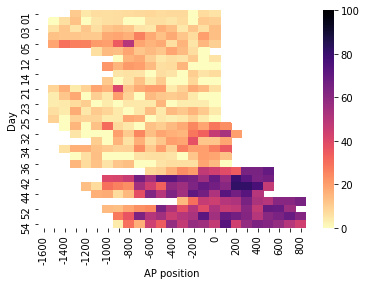

In [6]:
plot_ = sns.heatmap(magenta,vmin=0,vmax=100,cmap="magma_r")
plt.rcParams.update({'font.size': 14})
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.savefig('./exp_heatmap_magenta', dpi=300, bbox_inches='tight')

In [7]:
green = experiments.reset_index().drop(["double","mitosis","magenta"],axis=1)
green['x'] = green.apply(mix, axis=1)
green = green.groupby(["x","position"]).mean()
green = green.groupby(["x",pd.cut(green.reset_index().position.to_list(), bins)]).mean()
green = green.reset_index().rename(columns={"level_1":"position","x":"Day"})
green["AP position"] = green["position"].apply(lambda x: int((int(str(x).split(",")[0][1:])+int(str(x).split(",")[1][:-1]))/2))
# green = green.pivot(index='AP position', columns='Day', values='green').sort_index(ascending=False)
green = green.pivot(index='Day', columns='AP position', values='green').sort_index(ascending=True)

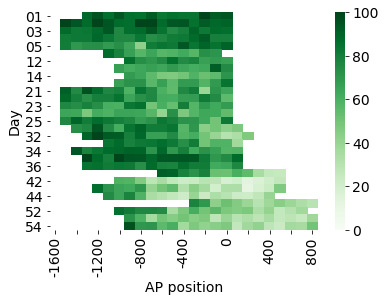

In [8]:
plot_ = sns.heatmap(green,vmin=0,vmax=100,cmap="Greens")
plt.rcParams.update({'font.size': 14})
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.savefig('./exp_heatmap_green', dpi=300, bbox_inches='tight')

In [9]:
double = experiments.reset_index().drop(["green","mitosis","magenta"],axis=1)
double['x'] = double.apply(mix, axis=1)
double = double.groupby(["x","position"]).mean()
double = double.groupby(["x",pd.cut(double.reset_index().position.to_list(), bins)]).mean()
double = double.reset_index().rename(columns={"level_1":"position","x":"Day"})
double["AP position"] = double["position"].apply(lambda x: int((int(str(x).split(",")[0][1:])+int(str(x).split(",")[1][:-1]))/2))
# double = double.pivot(index='AP position', columns='Day', values='double').sort_index(ascending=False)
double = double.pivot(index='Day', columns='AP position', values='double').sort_index(ascending=True)

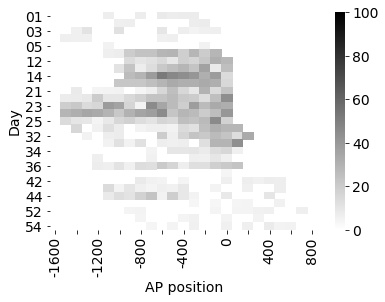

In [10]:
plot_ = sns.heatmap(double,vmin=0,vmax=100,cmap="gray_r")
plt.rcParams.update({'font.size': 14})
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.savefig('./exp_heatmap_double', dpi=300, bbox_inches='tight')

In [11]:
# Experiments
outgrowth_df = pd.read_csv('../data_analysis/outgrowth.csv')
outgrowth_df.set_index(['day', 'tail'], inplace=True)
outgrowth_mean = outgrowth_df.groupby('day').mean()['outgrowth']

percentage_df = pd.read_csv('../data_analysis/percentage_100um.csv')
df = percentage_df
for day in range(0,6):
    df.loc[df['day'] == day, 'position'] = (outgrowth_mean[day] - (df.loc[df['day'] == day, 'position']-100)).astype(int)
percentage_df = df
percentage_df.set_index(['day', 'tail', 'position'], inplace=True)
percentage_df = percentage_df.drop(['unlabelled'], axis=1)
experiments = percentage_df

In [24]:
# Simulations

# LINEAR RECRUITMENT
n0_mean,n0_std = 196,2 # n0 mean and standar deviation
l_mean,l_std = 828,30      # lambda mean and standar deviation
tau_mean,tau_std = 85,12   # tau mean and standar deviation
root = "./simulations/"
model = 'outgrowth_200seeds/'
parameters = 'n0='+str(n0_mean)+'\n'+'l='+str(l_mean)+'\n'+'tau='+str(tau_mean)+'/'

path = root+model+parameters
files = os.listdir(path)

all_seeds = []
intensity = {}
times = np.arange(0,6)
for seed in files:    
    all_times = []
    opened_file = open(path+seed)
    data = pd.read_csv(opened_file, delimiter=',')   
    data.set_index(['time', 'id'], inplace=True)
    intensity[seed] = data.xs(0,level='time').groupby('phase').count()['position']['S']   
    for day in times:
        data_time = data.xs(day*24,level='time')
        data_time = data_time.drop(['td','tc','recruited','dormant'], axis=1).dropna()
        
        exp_bins = percentage_df.xs(day,level='day').groupby('position').mean().index
        bins3 = (np.arange(exp_bins.min()-50,exp_bins.max()+150,100)).astype(int)
        data_time['range'] = pd.cut(data_time.position.to_list(), bins3)
        
        phases = data_time.dropna().groupby(['phase','range']).count().unstack('phase')['position'].fillna(0)
        if 'G2/M' not in phases:
            phases['G2/M'] = 0
        if 'G0' not in phases:
            phases['G0'] = 0      
        if 'D' not in phases:
            phases['D'] = 0            
            
        phases['green'] = round(((phases['G1']+phases['G0']) / (phases['G1']+phases['S']+phases['G2/M']+phases['G0']+phases['D']))*100,2)
        phases['magenta'] = round((phases['S'] / (phases['G1']+phases['S']+phases['G2/M']+phases['G0']+phases['D']))*100,2)
        phases['mitosris'] = round((phases['G2/M'] / (phases['G1']+phases['S']+phases['G2/M']+phases['G0']+phases['D']))*100,2)
        phases['double'] = round((phases['D'] / (phases['G1']+phases['S']+phases['G2/M']+phases['G0']+phases['D']))*100,2)
        #phases = phases.drop(['G1','S'],axis=1)
        phases['position'] = exp_bins
        phases.index = phases['position']
        phases = phases.drop('position',axis=1).dropna()
        
        all_times.append(phases)
    all_times = pd.concat(all_times, keys=[0,1,2,3,4,5], names=['day','id'])        
    all_seeds.append(all_times)
all_seeds = pd.concat(all_seeds, keys=np.arange(0,len(files)), names=['tail','day','position'])       
simulations = all_seeds.drop('G2/M',axis=1)
simulations = simulations.drop('G0',axis=1)
simulations_grouped = simulations.reset_index('tail')

In [25]:
bins2 = np.arange(0,200,20)
simulations_grouped = simulations_grouped.groupby([pd.cut(simulations_grouped['tail'],bins2),'day','position']).mean().dropna().drop('tail',axis=1)
simulations_grouped = simulations_grouped.reset_index().drop(["G1","S"],axis=1)

In [26]:
simulations_grouped['tail'] = simulations_grouped['tail'].apply(lambda x: int(int(str(x)[-4:-1])/20))

In [27]:
simulations_grouped0 = simulations_grouped.loc[(simulations_grouped['day'] == 0) & (simulations_grouped['tail'] <= 5)]
simulations_grouped1 = simulations_grouped.loc[(simulations_grouped['day'] == 1) & (simulations_grouped['tail'] <= 5)]
simulations_grouped2 = simulations_grouped.loc[(simulations_grouped['day'] == 2) & (simulations_grouped['tail'] <= 5)]
simulations_grouped3 = simulations_grouped.loc[(simulations_grouped['day'] == 3) & (simulations_grouped['tail'] <= 6)]
simulations_grouped4 = simulations_grouped.loc[(simulations_grouped['day'] == 4) & (simulations_grouped['tail'] <= 4)]
simulations_grouped5 = simulations_grouped.loc[(simulations_grouped['day'] == 5) & (simulations_grouped['tail'] <= 4)]     

In [28]:
simulations_grouped = pd.concat([simulations_grouped0,simulations_grouped1,simulations_grouped2,simulations_grouped3,simulations_grouped4,simulations_grouped5], ignore_index=True)

In [29]:
def mix_sim(x):
    return str(int(x['day'])) + str(x['tail'])

In [30]:
green = simulations_grouped.reset_index().drop(["magenta","double"],axis=1)
green['x'] = green.apply(mix_sim, axis=1)
green = green.groupby(["x","position"]).mean().drop("index",axis=1).reset_index()
green = green.groupby(["x",pd.cut(green.reset_index().position.to_list(), bins)]).mean()
green = green.drop("position",axis=1).reset_index().rename(columns={"level_1":"position","x":"Day"})
green["AP position"] = green["position"].apply(lambda x: int((int(str(x).split(",")[0][1:])+int(str(x).split(",")[1][:-1]))/2))
# green = green.pivot(index='AP position', columns='Day', values='green').sort_index(ascending=False)
green = green.pivot(index='Day', columns='AP position', values='green').sort_index(ascending=True)

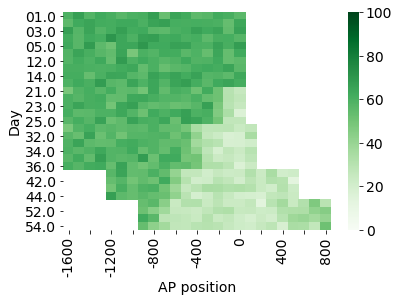

In [31]:
plot_ = sns.heatmap(green,vmin=0,vmax=100,cmap="Greens")
plt.rcParams.update({'font.size': 14})
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.savefig('./sim_heatmap_green', dpi=300, bbox_inches='tight')

In [32]:
magenta = simulations_grouped.reset_index().drop(["green","double"],axis=1)
magenta['x'] = magenta.apply(mix_sim, axis=1)
magenta = magenta.groupby(["x","position"]).mean().drop("index",axis=1).reset_index()
magenta = magenta.groupby(["x",pd.cut(magenta.reset_index().position.to_list(), bins)]).mean()
magenta = magenta.drop("position",axis=1).reset_index().rename(columns={"level_1":"position","x":"Day"})
magenta["AP position"] = magenta["position"].apply(lambda x: int((int(str(x).split(",")[0][1:])+int(str(x).split(",")[1][:-1]))/2))
# magenta = magenta.pivot(index='AP position', columns='Day', values='magenta').sort_index(ascending=False)
magenta = magenta.pivot(index='Day', columns='AP position', values='magenta').sort_index(ascending=True)

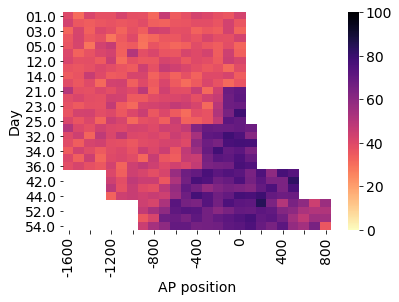

In [33]:
plot_ = sns.heatmap(magenta,vmin=0,vmax=100,cmap="magma_r")
plt.rcParams.update({'font.size': 14})
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.savefig('./sim_heatmap_magenta', dpi=300, bbox_inches='tight')